<a href="https://colab.research.google.com/github/RGivisiez/WcGAN-GP-MNIST/blob/main/WcGAN_GP_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

In this notebook, I will use a conditional GAN to generate numbers of the MNIST dataset. Because GANs requires a lot of computational resources, I will restrict the dataset size and the number of classes used. My main objective is to see the process of training a GAN.

To keep track of GAN's discriminator loss and visualize the quality of images generated, I will use the TensorBoard.

> To prevent the well know mode colapse that a vannila GAN presents, I will use the Wasserstein loss with a gradient penalty (WGAN-GP).

> **Tips:** Typically, the discriminator (critic) loss is expected to have negative values and fall very quickly at the beginning of the training, then rise again to near 0. This behaviour is expected of a stable GAN.

![epoch_d_loss](img/epoch_d_loss.svg)

# Imports

In [ ]:
import os
import io
import datetime

import matplotlib.pyplot as plt
from IPython import display
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import Model
tf.__version__

'2.7.0'

In [ ]:
%load_ext tensorboard

# Create the dataset

In [ ]:
#@title Downlad and normalize imagens
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

norm_image = 255 / 2.0

train_images = (train_images - norm_image) / norm_image  # Normalize the images to [-1, 1]

In [ ]:
#@title Set the train size and select the classes to consider (Default is 0 and 2).

train_size = 512 #@param {type:"integer"}
class_to_consider = [0, 2] #@param {type:"raw"}
num_class = len(class_to_consider)

print('Train size: {0} \nClasses: {1}'.format(train_size, class_to_consider))

Train size: 512 
Classes: [0, 2]


In [ ]:
#@title Restrict the train size and select the classes labels

mask = train_labels == class_to_consider[0]

for c in class_to_consider[1:]:
  mask = mask + (train_labels == c)

train_images = train_images[mask]
train_labels = train_labels[mask]

train_images = train_images[:train_size]
train_labels = train_labels[:train_size]

In [ ]:
# Buffer size must be big. 
# A rule of thumbs is to choose it equal
# to the dataset size.

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128

In [ ]:
#@title Make the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Models

In [ ]:
noise_dim = 128

In [ ]:
gen_input_shape = (noise_dim + num_class, )
disc_input_shape = (train_images.shape[1],
                    train_images.shape[2],
                    1 + num_class,)

In [ ]:
def make_generator1():

  model = tf.keras.Sequential(name='generator1')

  model.add(layers.Dense(7*7*256, input_shape=gen_input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape([7, 7, 256]))
  model.add(layers.Conv2DTranspose(128, 5, 1, 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, 5, 2, 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, 5, 2, 'same', activation='tanh'))

  return model

In [ ]:
def make_discriminator1():

  model = tf.keras.Sequential(name='discriminator1')

  model.add(layers.Conv2D(64, 5, 2, 'same', input_shape=disc_input_shape))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, 5, 2, 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def make_generator2():
    noise = layers.Input(shape=gen_input_shape)
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)
    
    g_model = keras.models.Model(noise, x, name="generator2")
    return g_model

In [ ]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def make_discriminator2():
    img_input = layers.Input(shape=disc_input_shape)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)
    
    d_model = keras.models.Model(img_input, x, name="discriminator2")
    return d_model

# WcGAN-GP class

In [ ]:
class WGAN(Model):
    def __init__(self, discriminator, generator, latent_dim,
                 d_extra_steps=3, gp_weight=10.0,):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_extra_steps = d_extra_steps
        self.gp_weight = gp_weight

    def compile(self, disc_opt, gen_opt, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.disc_opt = disc_opt
        self.gen_opt = gen_opt
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

            This loss is calculated on an interpolated image
            and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1])
        interpolated = real_images * alpha + fake_images * (1 - alpha)

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        
        return gp

    # Override the training step function of the Model class
    def train_step(self, data):

      images, labels = data

      batch_size = tf.shape(images)[0]

      one_hot_labels = tf.one_hot(labels, depth=num_class)

      image_one_hot_labels = tf.repeat(one_hot_labels,
                                 repeats=[disc_input_shape[0] * disc_input_shape[1]])

      image_one_hot_labels = tf.reshape(image_one_hot_labels,
                                        (-1, disc_input_shape[0], disc_input_shape[1], num_class))

      #---------Discriminator loop--------------

      for i in range(self.d_extra_steps):

        noise = tf.random.normal([batch_size, self.latent_dim])

        noise_labels = tf.concat([noise, one_hot_labels], axis=1)

        with tf.GradientTape() as disc_tape:
          
          G_output = self.generator(noise_labels, training=True)
          G_output = tf.concat([G_output, image_one_hot_labels], -1)
          images_and_labels = tf.concat([images, image_one_hot_labels], -1)
  
          D_fake_pred = self.discriminator(G_output, training=True)

          D_real_pred = self.discriminator(images_and_labels, training=True)

          gp = self.gradient_penalty(batch_size, images_and_labels, G_output)
          D_loss = self.d_loss_fn(D_real_pred, D_fake_pred, self.gp_weight, gp)

        D_grad = disc_tape.gradient(D_loss, self.discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(D_grad, self.discriminator.trainable_variables))
      
      #------Generator loop-------------

      noise = tf.random.normal([batch_size, self.latent_dim])

      noise_labels = tf.concat([noise, one_hot_labels], axis=1)

      with tf.GradientTape() as gen_tape:

        G_output = self.generator(noise_labels, training=True)
        G_output = tf.concat([G_output, image_one_hot_labels], -1)

        D_fake_pred = self.discriminator(G_output, training=True)

        G_loss = self.g_loss_fn(D_fake_pred)

      G_grad = gen_tape.gradient(G_loss, self.generator.trainable_variables)
      gen_opt.apply_gradients(zip(G_grad, self.generator.trainable_variables))

      return {'d_loss': D_loss, "g_loss": G_loss}

# Callbacks

In [ ]:
#@title Path to save the callbacks
logdir = "logs/Model-2"#os.path.join("logs", datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))

image_writer = tf.summary.create_file_writer(logdir + '/img')

print('Path logs: {0}'.format(logdir))

Path logs: logs/Model-2


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,
                                                      histogram_freq=5,
                                                      profile_batch = '2,3')

### Help functions

In [ ]:
def plot_to_image(figure):

  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)

  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  
  # Add the batch dimension
  image = tf.expand_dims(image, 0)

  return image

### **GeneratorImages**: callback to save images for TensorBoard

> **Warning**: This function use matplotlib and will slowdown the code, consider exclude GeneratorImages from the callback calls in model.fit().

In [ ]:
class GeneratorImages(keras.callbacks.Callback):
  def __init__(self, fixed_seed, save_step=10):
    self.fixed_seed = fixed_seed
    self.save_step = save_step

  def on_epoch_end(self, epoch, logs=None):

    if epoch % self.save_step == 0:

      display.clear_output(wait=True)
      print('Epoch {0}'.format(epoch + 1))

      labels = tf.range(0, num_class)
      one_hot_labels = tf.one_hot(labels, num_class)
      noise_labels = tf.concat([self.fixed_seed, one_hot_labels], axis=1)
      predictions = self.model.generator(noise_labels, training=False)

      predictions_img = predictions[:, :, :, 0] * 127.5 + 127.5
      
      fig = plt.figure(figsize=(8, 8))

      for i in range(predictions_img.shape[0]):
        plt.imshow(predictions_img[i, :, :], cmap='gray')
        plt.axis('off')

        with image_writer.as_default():
          tf.summary.image("Generator Images - {}".format(i), plot_to_image(fig), step=epoch)

# Loss function

In [ ]:
def W_gen_loss(fake_pred):
  return -tf.reduce_mean(fake_pred)

def W_disc_loss(real_pred, fake_pred, eps, grad_pen):
  return -tf.reduce_mean(real_pred) + tf.reduce_mean(fake_pred) + eps * grad_pen

# Model build and compile

There are two models that can be used:

  1. `make_generator1()` or `make_discriminator1()`
  2. `make_generator2()` or `make_discriminator2()`

> By default `make_discriminator2()` and `make_generator2()` are used, because they give better results.

In [ ]:
Generator = make_generator2()
Discriminator = make_discriminator2()

In [ ]:
disc_opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
gen_opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [ ]:
model = WGAN(Discriminator, Generator, noise_dim, d_extra_steps=3)

In [ ]:
model.compile(disc_opt, gen_opt, W_disc_loss, W_gen_loss)

# Model train

In [ ]:
#@title 
EPOCH =  700#@param {type:"integer"}

In [ ]:
#@title Run TensorBoard
%tensorboard --logdir logs --host 0.0.0.0

In [ ]:
# Seed used to creat new images at every epoch using the Generator.
# With a fixed seed, it is possible to see how the generator improves
# at every epoch.
fixed_seed = tf.random.normal([num_class, noise_dim], seed=42)

In [ ]:
hist = model.fit(train_dataset,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCH,
                 callbacks=[GeneratorImages(fixed_seed),
                            tensorboard_callback,
                            ]
                 )

Epoch 691
4/4 [==============================] - 5s 1s/step - d_loss: -3.4008 - g_loss: -9.3778
Epoch 692/700
4/4 [==============================] - 3s 831ms/step - d_loss: -3.2248 - g_loss: -9.0447
Epoch 693/700
4/4 [==============================] - 3s 793ms/step - d_loss: -3.6159 - g_loss: -9.1009
Epoch 694/700
4/4 [==============================] - 3s 790ms/step - d_loss: -3.4703 - g_loss: -8.7952
Epoch 695/700
4/4 [==============================] - 3s 791ms/step - d_loss: -3.3512 - g_loss: -9.5917
Epoch 696/700
4/4 [==============================] - 4s 1s/step - d_loss: -3.1629 - g_loss: -9.0833
Epoch 697/700
4/4 [==============================] - 3s 781ms/step - d_loss: -2.8746 - g_loss: -8.8627
Epoch 698/700
4/4 [==============================] - 3s 780ms/step - d_loss: -3.3518 - g_loss: -8.4206
Epoch 699/700
4/4 [==============================] - 3s 791ms/step - d_loss: -3.1163 - g_loss: -8.6230
Epoch 700/700
4/4 [==============================] - 3s 790ms/step - d_loss: -2.915

# Generate new images using the Discriminator

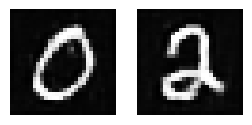

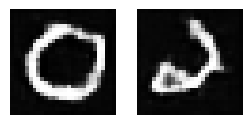

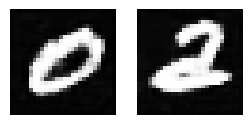

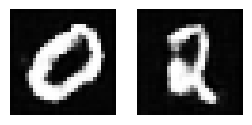

In [ ]:
#@title Number o images
n_images = 4 #@param {type:"integer"}

plt.close()

for _ in range(n_images):
  
  fixed_seed = tf.random.normal([num_class, noise_dim])

  labels = tf.range(0, num_class)
  one_hot_labels = tf.one_hot(labels, num_class)
  noise_labels = tf.concat([fixed_seed, one_hot_labels], axis=1)
  predictions = Generator(noise_labels, training=False)

  fig = plt.figure(figsize=(num_class+1, 2))

  for i in range(predictions.shape[0]):
      plt.subplot(1, num_class, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()